# Experimenting with transformers
Transformers remain as a promising replacement of RNNs due to their parallelizability. However, RNNs are unique in their hidden state which tends to be uniquely useful for games. 



In [19]:
import pickle
import torch
import pandas as pd
import importlib
import numpy as np
import utils
import data_processing_utils
import models

importlib.reload(data_processing_utils)
from data_processing_utils import *
importlib.reload(utils)
from utils import *
importlib.reload(models)
from models import *

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
grouped_df = pd.read_csv('../data/haha-longer-mid.csv')

In [4]:

    
def df_to_data_with_special_tokens(df, fixed_window=False, fixed_window_size=16, sampling_rate=1, algebraic_notation=True, old_vocab = None):
    """
    Input: Dataframe of training data in which each row represents a full game played between players
    Output: List in which each item represents some game's history up until a particular move, List in the same order in which the associated label is the following move
    """
    subsequences = []
    next_moves = []
    vocab = old_vocab 
    if vocab is None:
        vocab = VocabularyWithCLS()
    board = chess.Board()
    for game in df['moves']:
        moves = game.split()
        # Turn the game into a list of moves
        encoded_moves = [1]
        for move in moves:
            # Create a move object from the coordinate notation
            move_obj = chess.Move.from_uci(move)
            if move_obj not in board.legal_moves:
                break 
            else:
                if algebraic_notation:
                    algebraic_move = board.san(move_obj)
                    board.push(move_obj)
                    vocab.add_move(algebraic_move)
                    encoded_move = vocab.get_id(algebraic_move)
                    encoded_moves.append(encoded_move)
                else:
                    encoded_move = vocab.get_id(move)
                    encoded_moves.append(encoded_move)
        board.reset()
        # Turn the list of moves into subsequences
        for i in range(len(encoded_moves)-1):
            if random.uniform(0, 1) <= sampling_rate:
                subseq = encoded_moves[0:i+1]
                if fixed_window and len(subseq) > fixed_window_size:
                    subseq = subseq[-fixed_window_size:]
                label = encoded_moves[i+1]
                subsequences.append(subseq)
                next_moves.append(label)

    return subsequences, next_moves, vocab

In [11]:
with open('./../data/full_vocab_no_checkmate.pkl', 'rb') as inp:
    vocab = pickle.load(inp)
    
# with open('./../data/full_vocab.pkl', 'rb') as inp:
#     vocab = pickle.load(inp)


trainX, trainY, vocab = df_to_sequential_data(grouped_df, fixed_window=True, sampling_rate=0.5, old_vocab=vocab)
trainX, trainX_seqlengths  = pad_sequences(trainX)

In [20]:
# Function to load a memmap file
def load_memmap(filename, dtype, shape):
    # Load the memmap file with read-only mode
    return np.memmap(filename, dtype=dtype, mode='r', shape=shape)

In [21]:
# For trainX
dtype_trainX = np.int32  # or the correct dtype for your data
shape_trainX = (2161482, 750)  # replace with the correct shape
trainX = load_memmap('./../data/transformer/jan/trainX.memmap', dtype_trainX, shape_trainX)

# For trainY
dtype_trainY = np.int32 # or the correct dtype for your data
shape_trainY = (2161482, 7)  # replace with the correct shape
trainY = load_memmap('./../data/transformer/jan/trainY.memmap', dtype_trainY, shape_trainY)

with open('./../data/transformer/jan/vocab.pkl', 'rb') as inp:
    vocab = pickle.load(inp)

In [4]:
print(trainX[:1,:4])  

[[1 0 2 0]]


In [13]:

class TransformerDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences, self.labels = sequences, labels
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [14]:
dataset = TransformerDataset(trainX, trainY)
total_size = len(dataset)
# We're scaling the model size so let's bring in more data as well
train_size = int(0.97 * total_size)
val_size = int(total_size * 0.02)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)


11891042


In [15]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a long enough `pe` to be sliced according to any input `x` up to `max_len`
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # `x` is assumed to be of shape [batch_size, seq_length, d_model]
        # Adjust `pe` to match the dimensions of `x`
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class ChessTransformerDecoder(nn.Module):
    def __init__(self, vocab, d_model, nhead, num_layers, max_seq_length=750, dropout=0.1):
        super(ChessTransformerDecoder, self).__init__()
        self.vocab = vocab
        self.d_model =d_model
        self.vocab_size = len(vocab.id_to_move.keys())
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)
        
        # Only decoder is needed for autoregressive models
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, 
                                       nhead=nhead, 
                                       dropout=dropout,
                                       batch_first=True,),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        self.fc = nn.Linear(d_model, self.vocab_size)

    def forward(self, tgt):
        # Memory is optional and could be used for incorporating encoder states in a hybrid model
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        tgt_mask = self.square_subsequent_mask(tgt).to(tgt.device)

        # Embedding and Positional Encoding for tgt
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb).to(tgt.device)

        # Autoregressive decoding using the Transformer Decoder
        output = self.transformer_decoder(tgt_emb, memory=None,
                                          tgt_mask=tgt_mask,
                                          tgt_is_causal = True,
                                          tgt_key_padding_mask=tgt_padding_mask)
        
        # Linear layer to predict vocab
        output = self.fc(output)
        return output
    
    def create_padding_mask(self, src):
        PAD_IDX = 0
        src_padding_mask = (src == PAD_IDX)
        return src_padding_mask
    
    def square_subsequent_mask(self, tgt):
        """ Generate a square mask for the sequence to mask out subsequent positions. """
        sz = tgt.size(1)
        mask = torch.triu(torch.ones(sz, sz, device=tgt.device, dtype=torch.bool), diagonal=1)
        return mask


class ChessTransformerTwo(nn.Module):
    def __init__(self, vocab, d_model, nhead, num_layers, max_seq_length=16, dropout=0.1):
        super(ChessTransformerTwo, self).__init__()
        self.vocab = vocab
        self.d_model = d_model
        self.vocab_size = len(vocab.id_to_move.keys())
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)
        self.pos_encoder_two = PositionalEncoding(d_model, dropout, 1)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, 
                                          batch_first=True)
        self.fc = nn.Linear(d_model, self.vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, src, tgt):
        # Create source padding mask
        src_padding_mask = self.create_padding_mask(src).to(src.device, non_blocking=True)
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device, non_blocking=True)
        # Embedding and Positional Encoding for src

        src_emb = self.embedding(src) * math.sqrt(self.d_model) # [batch_size, seq_len] -> [batch_size, seq_len, d_model]

        src_emb = self.pos_encoder(src_emb).to(tgt.device, non_blocking=True)
        
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model) # [batch_size, seq_len] -> [batch_size, seq_len, d_model]

        tgt_emb = self.pos_encoder_two(tgt_emb).to(tgt.device, non_blocking=True)
    
        # Transformer
        output = self.transformer(src_emb, tgt_emb, 
                                  src_key_padding_mask=src_padding_mask, 
                                  tgt_key_padding_mask=tgt_padding_mask)
        # Linear layer to predict vocab
        output = self.fc(output)
        return output
    
    def create_padding_mask(self, src):
        PAD_IDX = 0
        src_padding_mask = (src == PAD_IDX)
        return src_padding_mask
    
    def square_subsequent_mask(self, tgt):
        """
        Generate a square mask for the sequence. The masked positions are filled with `True`.
        This mask ensures that for any position `i` in `tgt`, the decoder's self-attention mechanism
        can only attend to positions at or before `i`.
        
        Args:
            tgt (Tensor): The target input tensor of shape [batch_size, tgt_len].
        
        Returns:
            Tensor: A mask of shape [tgt_len, tgt_len] where `True` indicates that attention is not allowed.
        """
        # tgt_len could be derived from the second dimension of tgt
        tgt_len = tgt.size(1)
        
        # Generate an upper triangular matrix with `True` in the upper triangle
        mask = torch.triu(torch.ones((tgt_len, tgt_len), dtype=torch.bool), diagonal=1)
        return mask
    
class ChessTransformerDecoder(nn.Module):
    def __init__(self, vocab, d_model, nhead, num_layers, max_seq_length=750, dropout=0.1):
        super(ChessTransformerDecoder, self).__init__()
        self.vocab = vocab
        self.d_model =d_model
        self.vocab_size = len(vocab.id_to_move.keys())
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)
        
        # Only decoder is needed for autoregressive models
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, 
                                       nhead=nhead, 
                                       dropout=dropout,
                                       batch_first=True,),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        self.fc = nn.Linear(d_model, self.vocab_size)

    def forward(self, tgt):
        # Memory is optional and could be used for incorporating encoder states in a hybrid model
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        tgt_mask = self.square_subsequent_mask(tgt).to(tgt.device)

        # Embedding and Positional Encoding for tgt
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb).to(tgt.device)

        # Autoregressive decoding using the Transformer Decoder
        output = self.transformer_decoder(tgt_emb, memory=None,
                                          tgt_mask=tgt_mask,
                                          tgt_is_causal = True,
                                          tgt_key_padding_mask=tgt_padding_mask)
        
        # Linear layer to predict vocab
        output = self.fc(output)
        return output
    
    def create_padding_mask(self, src):
        PAD_IDX = 0
        src_padding_mask = (src == PAD_IDX)
        return src_padding_mask
    
    def square_subsequent_mask(self, tgt):
        """ Generate a square mask for the sequence to mask out subsequent positions. """
        sz = tgt.size(1)
        mask = torch.triu(torch.ones(sz, sz, device=tgt.device, dtype=torch.bool), diagonal=1)
        return mask


class ChessTransformer(nn.Module):
    def __init__(self, vocab, d_model, nhead, num_layers, max_seq_length=750, dropout=0.1):
        super(ChessTransformer, self).__init__()
        self.vocab = vocab
        self.d_model = d_model
        self.vocab_size = len(vocab.id_to_move.keys())
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, 
                                          batch_first=True)
        self.fc = nn.Linear(d_model, self.vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, src, tgt):

        # Create source padding mask
        src_padding_mask = self.create_padding_mask(src).to(src.device)
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        # Embedding and Positional Encoding for src

        src_emb = self.embedding(src) * math.sqrt(self.d_model) # [batch_size, seq_len] -> [batch_size, seq_len, d_model]

        src_emb = self.pos_encoder(src_emb).to(tgt.device)
        
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model) # [batch_size, seq_len] -> [batch_size, seq_len, d_model]

        tgt_emb = self.pos_encoder(tgt_emb).to(tgt.device)
    
        # Transformer
        output = self.transformer(src_emb, tgt_emb, 
                                  src_key_padding_mask=src_padding_mask, 
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  tgt_is_causal = True,
                                  src_is_causal = True, 
                                  src_mask = self.square_subsequent_mask(src).to(src.device),
                                  tgt_mask = self.square_subsequent_mask(tgt).to(tgt.device))
        # Linear layer to predict vocab
        output = self.fc(output)
        return output
    
    def create_padding_mask(self, src):
        PAD_IDX = 0
        src_padding_mask = (src == PAD_IDX)
        return src_padding_mask
    
    def square_subsequent_mask(self, tgt):
        """
        Generate a square mask for the sequence. The masked positions are filled with `True`.
        This mask ensures that for any position `i` in `tgt`, the decoder's self-attention mechanism
        can only attend to positions at or before `i`.
        
        Args:
            tgt (Tensor): The target input tensor of shape [batch_size, tgt_len].
        
        Returns:
            Tensor: A mask of shape [tgt_len, tgt_len] where `True` indicates that attention is not allowed.
        """
        # tgt_len could be derived from the second dimension of tgt
        tgt_len = tgt.size(1)
        
        # Generate an upper triangular matrix with `True` in the upper triangle
        mask = torch.triu(torch.ones((tgt_len, tgt_len), dtype=torch.bool), diagonal=1)
        return mask
    
    def generate_sequence(self, src, src_length, start_symbol_id, sep_token_id, max_length=100):
        """
        Generate a sequence autoregressively using the trained transformer model.

        Args:
        - src (Tensor): The input source sequence tensor.
        - src_length (Tensor): The length of the source sequence.
        - start_symbol_id (int): The ID of the start symbol to begin generation.
        - sep_token_id (int): The ID of the SEP token for sequence termination.
        - max_length (int): Maximum length of the generated sequence to prevent infinite loops.

        Returns:
        - The generated sequence tensor.
        """
        self.eval()  # Ensure the model is in eval mode

        # Initialize the target sequence with the start symbol
        tgt = torch.tensor([start_symbol_id], dtype=torch.long).to(src.device)
        
        for _ in range(max_length):
            # Assuming src_length is a tensor with the length of src. Adjust as needed.

            # Perform a forward pass to get logits for the next token
            logits = self.forward(src, src_length, tgt, src)
            # Get the last token logits and apply softmax to get probabilities
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            # get most likely token from probs
            next_token = torch.max(probs, 1)
            
            # Append the predicted token to the target sequence
            tgt = torch.cat((tgt, next_token), dim=1)
            
            # Check if the <SEP> token is generated
            if next_token.item() == sep_token_id:
                break

        return tgt


Functions for training

In [16]:
# Function to calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    top3 = torch.topk(y_pred, 3, dim=1).indices
    correct = top3.eq(y_true.view(-1, 1).expand_as(top3))
    return correct.any(dim=1).float().mean().item()

def train_last_token(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        count = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # Forward Pass

            # Check if your data contains zeros as padding, and modify 'greater(0)' if different padding
            non_zero_mask = (sequences != 0) 
            last_non_zero_indices = non_zero_mask.long().argmax(dim=1)  # Gets the index of the first zero after last non-zero
            
            # Correction for sequences entirely non-zero or wrongly identified first zero indices
            last_non_zero_indices = torch.where(
                non_zero_mask.any(dim=1),
                non_zero_mask.sum(dim=1) - 1,  # Last non-zero index
                torch.tensor(0).to(device)  # Default to 0 if no non-zero found (edge case)
            )

            # Gather the last non-zero tokens for each sequence in the batch
            last_non_zero_tokens = sequences[torch.arange(sequences.size(0)), last_non_zero_indices]

            # Forward Pass using the last non-zero token


            logits = model(sequences, last_non_zero_tokens.unsqueeze(1))
            loss = criterion(logits.view(-1, model.vocab_size),labels)

            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            # Clip it
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
            optimizer.step()

            # For logging purposes
            training_loss += loss.item()
            # Calculate accuracy
            _, predicted = torch.max(logits, dim=2)
            predicted_last = predicted[:, -1]
            train_correct += (predicted_last == labels).sum().item()
            train_total += predicted_last.size(0)  # Same as tgt_labels_last.size(0), which is the batch size
            count += 1
            
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count} | Training Accuracy: {train_correct/train_total}')
        # Validation
        model.eval()

        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                val_loss = 0

                for sequences, labels in val_loader:
                    sequences, labels = sequences.to(device), labels.to(device)
                    # Check if your data contains zeros as padding, and modify 'greater(0)' if different padding
                    non_zero_mask = (sequences != 0) 
                    last_non_zero_indices = non_zero_mask.long().argmax(dim=1)  # Gets the index of the first zero after last non-zero
                    
                    # Correction for sequences entirely non-zero or wrongly identified first zero indices
                    last_non_zero_indices = torch.where(
                        non_zero_mask.any(dim=1),
                        non_zero_mask.sum(dim=1) - 1,  # Last non-zero index
                        torch.tensor(0).to(device)  # Default to 0 if no non-zero found (edge case)
                    )

                    # Gather the last non-zero tokens for each sequence in the batch
                    last_non_zero_tokens = sequences[torch.arange(sequences.size(0)), last_non_zero_indices]

                    # Forward Pass using the last non-zero token


                    logits = model(sequences, last_non_zero_tokens.unsqueeze(1))
                    loss = criterion(logits.view(-1, model.vocab_size),labels)

                    # For logging purposes
                    val_loss += loss.item()
                     # Calculate accuracy
                    _, predicted = torch.max(logits, dim=2)
                    predicted_last = predicted[:, -1]
                    val_correct += (predicted_last == labels).sum().item()
                    val_total += predicted_last.size(0)  # Same as tgt_labels_last.size(0), which is the batch size
                    count += 1
                val_loss_values.append(val_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)
        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

def train_decoder(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        count = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # Forward Pass
            tgt_labels = torch.cat([sequences[:,1:],labels.unsqueeze(1)],dim=1).to(device)
            logits = model(sequences, sequences)
            loss = criterion(logits.view(-1, model.vocab_size), tgt_labels.view(-1))

            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            # Clip it
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
            optimizer.step()

            # For logging purposes
            training_loss += loss.item()
            # Calculate accuracy
            _, predicted = torch.max(logits, dim=2)
            # Selecting only the last token from each sequence in the batch
            predicted_last = predicted[:, -1]
            tgt_labels_last = tgt_labels[:, -1]

            # Updating the correct count based on the last token predictions
            train_correct += (predicted_last == tgt_labels_last).sum().item()
            # Updating the total count to reflect that only one token per sequence is considered
            train_total += predicted_last.size(0)  # Same as tgt_labels_last.size(0), which is the batch size
            # train_correct += (predicted == tgt_labels).sum().item()
            # train_total += tgt_labels.numel()
            count += 1
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count} | Training Accuracy: {train_correct/train_total}')
        # Validation
        model.eval()

        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                val_loss = 0

                for sequences, labels in val_loader:
                    sequences, labels = sequences.to(device), labels.to(device)
                    tgt_labels = torch.cat([sequences[:,1:],labels.unsqueeze(1)],dim=1).to(device)
                    logits = model(sequences, sequences)
                    loss = criterion(logits.view(-1, model.vocab_size), tgt_labels.view(-1))

                    # For logging purposes
                    val_loss += loss.item()
                    # Calculate accuracy
                    _, predicted = torch.max(logits, dim=2)
                    # Selecting only the last token from each sequence in the batch
                    predicted_last = predicted[:, -1]
                    tgt_labels_last = tgt_labels[:, -1]

                    # Updating the correct count based on the last token predictions
                    val_correct += (predicted_last == tgt_labels_last).sum().item()
                    # Updating the total count to reflect that only one token per sequence is considered
                    val_total += predicted_last.size(0)  # Same as tgt_labels_last.size(0), which is the batch size

                val_loss_values.append(val_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)
        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

def train_transformer(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, labels in train_loader:
            count += 1
            sequences, labels = sequences.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # Forward Pass
            logits = model(sequences, labels)
            print(logits)
            loss = criterion(logits.view(-1, model.vocab_size), labels.contiguous().view(-1))
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            # Clip it
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            # _, predicted = torch.max(output.data, 1)
            # train_total += labels.size(0)
            # train_correct += (predicted == labels).sum().item()
            # Get the predicted class indices for each position in each sequence
            _, predicted = torch.max(logits.data, dim=2)  # Shape: (batch_size, seq_length)
            correct_predictions = predicted == labels  # Shape: (batch_size, seq_length)
            correct_sequences = correct_predictions.all(dim=1)  # Shape: (batch_size)
            train_correct += correct_sequences.sum().item()
            train_total += labels.size(0) 
            break
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        # if val_loader is not None:
        #     with torch.no_grad():
        #         val_correct = 0
        #         val_total = 0
        #         val_top3_correct = 0
        #         validation_loss = 0

        #         for sequences, lengths, labels in val_loader:
        #             sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        #             outputs = model.generate(sequences, lengths)
        #             _, predicted = torch.max(outputs.data, 1)
        #             val_total += labels.size(0)
        #             val_correct += (predicted == labels).sum().item()
        #             val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
        #             loss = criterion(outputs, labels)
        #             validation_loss += loss.item()

        #         val_loss_values.append(validation_loss / len(val_loader))
        #         val_accuracy = 100 * val_correct / val_total
        #         val_top3_accuracy = 100 * val_top3_correct / val_total
        #         val_error.append(100 - val_accuracy)
        #         val_3_accuracy.append(val_top3_accuracy)
        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

# Experiments


## Experiment 1

In [24]:
# Reload the data with particular batch size
# torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 128
NUM_EPOCHS = 10
vocab_size = len(vocab.id_to_move.keys())
nhead = 8
num_layers = 2
model = ChessTransformer(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_id('<PAD>'))  # Assuming you have a PAD token
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.65 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

5207314


Epoch 1, Batch: 1000| Training Loss: 4.277270253896713 | Training Accuracy: 0.06821875
Epoch 1, Batch: 2000| Training Loss: 3.3310693102478983 | Training Accuracy: 0.071109375
Epoch 1, Batch: 3000| Training Loss: 2.7611966275374096 | Training Accuracy: 0.072140625
Epoch 1, Batch: 4000| Training Loss: 2.406634035587311 | Training Accuracy: 0.07366796875
Epoch 1, Batch: 5000| Training Loss: 2.1669605624198915 | Training Accuracy: 0.075484375
Epoch 1, Batch: 6000| Training Loss: 1.9921583703259627 | Training Accuracy: 0.07734114583333333
Epoch 1, Batch: 7000| Training Loss: 1.8581724826863835 | Training Accuracy: 0.07928571428571428
Epoch 1, Batch: 8000| Training Loss: 1.7539799907431006 | Training Accuracy: 0.0808203125
Epoch 1, Batch: 9000| Training Loss: 1.6695201332966487 | Training Accuracy: 0.08231770833333334
Epoch 1, Batch: 10000| Training Loss: 1.5988527409672737 | Training Accuracy: 0.0835015625
Epoch 1, Batch: 11000| Training Loss: 1.5384822490432046 | Training Accuracy: 0.0846

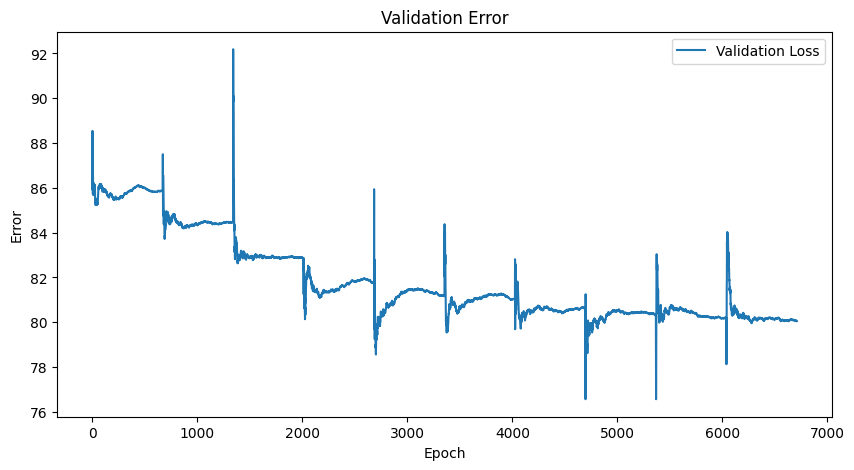

<Figure size 640x480 with 0 Axes>

In [25]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_decoder(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('transformer-decoder-4-22.png')  # This will save the plot as an image

In [26]:
torch.save(model.state_dict(), 'model_images/seq-transformer-exp-1.pth')

## Experiment 2 (different training schema -- only predict last token of sequence and backprop on that alone)

In [74]:
# Reload the data with particular batch size
# torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 128
NUM_EPOCHS = 10
vocab_size = len(vocab.id_to_move.keys())
nhead = 8
num_layers = 2
model = ChessTransformerTwo(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss() 
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.65 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

5207314


In [2]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_last_token(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('transformer-decoder-last-token-4-22.png')  # This will save the plot as an image

NameError: name 'device' is not defined

## Experiment 3 (higher d_model & num_layers)

In [20]:
# Reload the data with particular batch size
# torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 256
NUM_EPOCHS = 10
vocab_size = len(vocab.id_to_move.keys())
nhead = 8
num_layers = 4
model = ChessTransformer(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_id('<PAD>'))  # Assuming you have a PAD token
lr = 2e-4
weight_decay=1e-7
learn_decay = 0.8 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

16970002


In [21]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_decoder(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('training_results/transformer-exp-3-4-22.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 3.1954081513881682 | Training Accuracy: 0.0639765625
Epoch 1, Batch: 2000| Training Loss: 1.9873469138741493 | Training Accuracy: 0.075162109375
Epoch 1, Batch: 3000| Training Loss: 1.492823544184367 | Training Accuracy: 0.08463932291666666
Epoch 1, Batch: 4000| Training Loss: 1.2290759043172002 | Training Accuracy: 0.0930126953125
Epoch 1, Batch: 5000| Training Loss: 1.065340001809597 | Training Accuracy: 0.100221875
Epoch 1, Batch: 6000| Training Loss: 0.9532748395303885 | Training Accuracy: 0.10650065104166667
Epoch 1, Batch: 7000| Training Loss: 0.871701592539038 | Training Accuracy: 0.11183537946428572
Epoch 1, Batch: 8000| Training Loss: 0.809373230125755 | Training Accuracy: 0.1165244140625
Epoch 1, Batch: 9000| Training Loss: 0.7600478604402807 | Training Accuracy: 0.1206796875
Epoch 1, Batch: 10000| Training Loss: 0.720000497496128 | Training Accuracy: 0.124434765625
Epoch 1, Batch: 11000| Training Loss: 0.686838518535549 | Training Accurac

## Experiment 4 (no checkmate model)

In [17]:
# Reload the data with particular batch size
# torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 256
NUM_EPOCHS = 10
vocab_size = len(vocab.id_to_move.keys())
nhead = 8
num_layers = 4
model = ChessTransformer(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_id('<PAD>'))  # Assuming you have a PAD token
lr = 2e-4
weight_decay=1e-7
learn_decay = 0.8 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

16628344


In [20]:
print(vocab.move_to_id.keys())

dict_keys(['<UNK>', 'CLS', 'e4', 'd5', 'exd5', 'Qxd5', 'Nc3', 'Qd8', 'd4', 'e6', 'Nf3', 'Nf6', 'Bg5', 'Be7', 'Qd2', 'h6', 'Bh4', 'g5', 'Bg3', 'g4', 'Ne5', 'h5', 'h3', 'Bd6', 'Be2', 'Nbd7', 'O-O', 'd3', 'c6', 'Nxf3+', 'Bxf3', 'Ne2', 'Bc5', 'c3', 'Re8', 'a4', 'Bf5', 'b4', 'Be4', 'Bxe4', 'Rxe4', 'Bxf6', 'Qxf6', 'Ng3', 'Re6', 'Qd3', 'Qg6', 'Qf3', 'Rae8', 'Nh5', 'Qc2', 'Qd1', 'Qxc3', 'Rb1', 'Re2', 'e5', 'exd4', 'Qxd4', 'Nc6', 'Qe3', 'd6', 'Bb5', 'Bxc6', 'bxc6', 'dxe4', 'Nxe4', 'Qxe4', 'Qxc6', 'Bd7', 'Qb7', 'Rb8', 'c4', 'dxc4', 'Nd5', 'Qa4+', 'Qd7', 'Qxc4', 'Nxc3', 'bxc3', 'Bf4', 'e3', 'Bd3', 'Bxg5', 'Nxg5', 'Qe7', 'Qb3', 'Na5', 'Bc6', 'Qd6', 'Bxc6+', 'Qxc6+', 'Bb4', 'dxe5', 'Nc5', 'a3', 'Ba5', 'Qxc5', 'Bb6', 'Qc4', 'Qe4', 'f5', 'Qc4+', 'Be6', 'Qa4', 'exf4', 'Kh8', 'Qxf4', 'Nd4', 'Nxd4', 'Bxd4', 'Nb5', 'Rfe1', 'Rad8', 'c5', 'a5', 'axb6', 'cxd3', 'bxa7', 'd2', 'Red1', 'Bd5', 'Nc7', 'Rf8', 'a8=Q', 'Rxa8', 'Nxa8', 'gxf6', 'Bxc3+', 'cxd5', 'Qe6', 'dxc6', 'O-O-O', 'Bg4', 'Qc5', 'b6', 'Rfd1', 'Rd6

In [18]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_decoder(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('training_results/transformer-exp-3-4-22.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 3.164531381011009 | Training Accuracy: 0.06498046875
Epoch 1, Batch: 2000| Training Loss: 1.965106923520565 | Training Accuracy: 0.075517578125
Epoch 1, Batch: 3000| Training Loss: 1.4816381523311137 | Training Accuracy: 0.08402864583333333
Epoch 1, Batch: 4000| Training Loss: 1.2242640992924572 | Training Accuracy: 0.092001953125
Epoch 1, Batch: 5000| Training Loss: 1.0634873887717724 | Training Accuracy: 0.09899296875
Epoch 1, Batch: 6000| Training Loss: 0.9529955608894428 | Training Accuracy: 0.10500911458333333


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_images/seq-transformer-exp-4.pth')

## Experimenrt 5 (512 dim)

In [21]:
# Reload the data with particular batch size
# torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 512
NUM_EPOCHS = 10
vocab_size = len(vocab.id_to_move.keys())
nhead = 8
num_layers = 4
model = ChessTransformer(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_id('<PAD>'))  # Assuming you have a PAD token
lr = 1e-4
weight_decay=1e-7
learn_decay = 0.8 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

39521912


In [22]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_decoder(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('training_results/transformer-exp-3-4-22.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 3.3118682713508605 | Training Accuracy: 0.064578125
Epoch 1, Batch: 2000| Training Loss: 2.1279233896136285 | Training Accuracy: 0.07708984375
Epoch 1, Batch: 3000| Training Loss: 1.592337130745252 | Training Accuracy: 0.08634895833333334
Epoch 1, Batch: 4000| Training Loss: 1.3039989030361177 | Training Accuracy: 0.095490234375
Epoch 1, Batch: 5000| Training Loss: 1.1243414255440236 | Training Accuracy: 0.1036328125
Epoch 1, Batch: 6000| Training Loss: 1.0012873452206452 | Training Accuracy: 0.11042317708333334
Epoch 1, Batch: 7000| Training Loss: 0.9115567641598837 | Training Accuracy: 0.11628013392857142
Epoch 1, Batch: 8000| Training Loss: 0.8430284378342331 | Training Accuracy: 0.12156640625
Epoch 1, Batch: 9000| Training Loss: 0.7888814149432712 | Training Accuracy: 0.1261935763888889
Epoch 1, Batch: 10000| Training Loss: 0.7449112012445926 | Training Accuracy: 0.1305109375
Epoch 1, Batch: 11000| Training Loss: 0.7084411645612934 | Training Ac

KeyboardInterrupt: 

In [23]:
torch.save(model.state_dict(), 'model_images/seq-transformer-exp-5.pth')

# Special Tokenized Scheme -- Transformer